# Filipino-English BERT Translation Model Training

This notebook trains a BERT-style encoder-decoder model for Filipino-English translation on Google Colab.

**Hardware recommendation:** GPU runtime (T4 or better)

**Runtime:** Runtime → Change runtime type → GPU

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install -q datasets transformers tokenizers torch accelerate evaluate sacrebleu

print("✓ Packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 13.7 MB/s eta 0:00:00
✓ Packages installed!


In [2]:
# Check GPU availability
import torch

if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  No GPU detected. Go to Runtime → Change runtime type → GPU")

✓ GPU available: NVIDIA A100-SXM4-80GB
  Memory: 85.09 GB


## 2. Mounting Google Drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Create a project folder in your Drive
!mkdir -p '/content/drive/MyDrive/filipino_english_translation'

PROJECT_DIR = '/content/drive/MyDrive/filipino_english_translation'
print(f"✓ Project directory: {PROJECT_DIR}")

Mounted at /content/drive
✓ Project directory: /content/drive/MyDrive/filipino_english_translation


## 3. Load Dataset

**[rhyliieee/tagalog-filipino-english-translation](https://huggingface.co/datasets/rhyliieee/tagalog-filipino-english-translation)** is a Tagalog–English parallel corpus compiled from several existing sources: TalkTogether (Nag et al., 2024; [OSF](https://doi.org/10.17605/OSF.IO/3ZDFN)), DIBT/MPEP_FILIPINO, and saillab/alpaca_tamil_taco. The dataset has ~105K sentence pairs and is loaded via Hugging Face `datasets`; columns are `tagalog` (source) and `english` (target).

In [4]:
from datasets import load_dataset

# Load the Filipino-English translation dataset
print("Loading dataset...")
ds = load_dataset("rhyliieee/tagalog-filipino-english-translation")

print("\nDataset info:")
print(ds)
print(f"\nTrain samples: {len(ds['train'])}")
print(f"Test samples: {len(ds['test'])}")

# Show sample
print("\nSample translation:")
sample = ds['train'][0]
print(f"Tagalog: {sample['tagalog']}")
print(f"English: {sample['english']}")

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/736 [00:00<?, ?B/s]

train_data.csv:   0%|          | 0.00/68.5M [00:00<?, ?B/s]

test_data.csv:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/84177 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21057 [00:00<?, ? examples/s]


Dataset info:
DatasetDict({
    train: Dataset({
        features: ['tagalog', 'english'],
        num_rows: 84177
    })
    test: Dataset({
        features: ['tagalog', 'english'],
        num_rows: 21057
    })
})

Train samples: 84177
Test samples: 21057

Sample translation:
Tagalog:  Ilarawan kung ano ang makikita mo kung pupunta ka sa Grand Canyon.
English: Describe what you would see if you went to the Grand Canyon.


## 4. Training Tokenizer

Retraining tokenizer here because it's faster to just retrain it from scratch as opposed to loading the one I trained locally.


In [ ]:
from transformers import PreTrainedTokenizerFast
import os


print("Training new tokenizer...")
from datasets import concatenate_datasets
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

# Combine datasets
all_text = concatenate_datasets([ds["train"], ds["test"]])

def text_generator():
    for row in all_text:
        yield row["tagalog"]
        yield row["english"]

# Initialize and train
tokenizer_obj = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer_obj.pre_tokenizer = Whitespace()

trainer = BpeTrainer(
    vocab_size=32000,
    special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]", "[MASK]"]
)

tokenizer_obj.train_from_iterator(text_generator(), trainer=trainer)

# Wrap as transformers tokenizer
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer_obj,
    bos_token="[BOS]",
    eos_token="[EOS]",
    unk_token="[UNK]",
    pad_token="[PAD]",
    mask_token="[MASK]"
)

# Save to local and Drive
tokenizer.save_pretrained("/content/fil_en_bpe_tokenizer")
#tokenizer.save_pretrained(f"{PROJECT_DIR}/fil_en_bpe_tokenizer")
print("✓ Tokenizer trained and saved!")

print(f"\nVocab size: {tokenizer.vocab_size}")
print(f"Special tokens: {tokenizer.all_special_tokens}")

Training new tokenizer...
✓ Tokenizer trained and saved!

Vocab size: 32000
Special tokens: ['[BOS]', '[EOS]', '[UNK]', '[PAD]', '[MASK]']


## 5. Preprocess Dataset

In [ ]:
# Configuration
MAX_LENGTH = 128  # Max sequence length

def preprocess_function(examples):
    """
    Tokenize both source (Tagalog) and target (English) texts.
    """
    # Tokenize inputs (Tagalog)
    model_inputs = tokenizer(
        examples["tagalog"],
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length"
    )

    # Tokenize targets (English) without padding first
    labels = tokenizer(
        examples["english"],
        max_length=MAX_LENGTH - 2,  # Leave room for BOS and EOS
        truncation=True,
        padding=False  # Don't pad yet
    )

    # Manually add BOS and EOS tokens to labels
    label_ids = []
    for label in labels["input_ids"]:
        # Add BOS at start, EOS at end, then pad
        final_label = [tokenizer.bos_token_id] + label + [tokenizer.eos_token_id]
        # Pad to max length
        final_label += [tokenizer.pad_token_id] * (MAX_LENGTH - len(final_label))
        label_ids.append(final_label)

    model_inputs["labels"] = label_ids

    return model_inputs

In [8]:
# Tokenize datasets
print("Tokenizing datasets...")
tokenized_datasets = ds.map(
    preprocess_function,
    batched=True,
    remove_columns=ds["train"].column_names,
    desc="Tokenizing"
)

print("✓ Tokenization complete!")
print(f"Train samples: {len(tokenized_datasets['train'])}")
print(f"Test samples: {len(tokenized_datasets['test'])}")

Tokenizing datasets...


Tokenizing:   0%|          | 0/84177 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/21057 [00:00<?, ? examples/s]

✓ Tokenization complete!
Train samples: 84177
Test samples: 21057


Checking if the labels have the special tokens [BOS] and [EOS] because previous training runs failed because the [EOS] token was missing from labels so the model failed to learn to generate

In [9]:
sample = tokenized_datasets["train"][0]
print(f"First 10 label tokens: {sample['labels'][:10]}")
print(f"Last 20 label tokens: {sample['labels'][-20:]}")
print(f"Contains BOS (2)? {2 in sample['labels']}")
print(f"Contains EOS (3)? {3 in sample['labels']}")
print(f"Decoded: {tokenizer.decode([l for l in sample['labels'] if l != 0])}")

First 10 label tokens: [2, 2419, 1829, 840, 1314, 2259, 806, 840, 5978, 659]
Last 20 label tokens: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Contains BOS (2)? True
Contains EOS (3)? True
Decoded: [BOS] Describe what you would see if you went to the Grand Canyon . [EOS]


## 6. Create Model Architecture

Using BERT encoder-decoder architecture for translation.

In [ ]:
from transformers import EncoderDecoderModel, BertConfig, BertModel, BertLMHeadModel

# Model configuration

encoder_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,          
    num_hidden_layers=12,     
    num_attention_heads=12,   
    intermediate_size=3072,   
    max_position_embeddings=MAX_LENGTH,
    pad_token_id=tokenizer.pad_token_id,
)

decoder_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,          
    num_hidden_layers=12,    
    num_attention_heads=12,   
    intermediate_size=3072,   
    max_position_embeddings=MAX_LENGTH,
    is_decoder=True,
    add_cross_attention=True,  # Enable cross-attention for seq2seq
    pad_token_id=tokenizer.pad_token_id,
)

# Create encoder and decoder models first
print("Creating model...")
encoder = BertModel(encoder_config)
decoder = BertLMHeadModel(decoder_config)

# Create encoder-decoder model
model = EncoderDecoderModel(encoder=encoder, decoder=decoder)

# Set special tokens in config
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = tokenizer.vocab_size
model.config.bos_token_id = tokenizer.bos_token_id  # Also set bos_token_id

# Set generation config (needed for evaluation)
from transformers import GenerationConfig
model.generation_config = GenerationConfig(
    decoder_start_token_id=tokenizer.bos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    max_length=MAX_LENGTH,
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model created!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1e9:.2f} GB (fp32)")

I used the package `torchvista` to help visualize the architecture. I did this in Colab and saved the html output. I'm just rendering the HTML here. The visual is interactive, so you can expand the different module to see the underlying contents. The left side of the visual shows the decoder and the right side shows the encoder. There are 12 encoder/decoder blocks on each side and it's cool to see where exactly the encoder outputs feed into the decoder blocks.

**Architecture notes:** Inputs are token IDs `(batch, seq_len)` with vocab size and max length 128. **Hidden size** is 768; each block has **12 attention heads** (64 dim/head). The feed-forward layer in each block uses **intermediate_size=3072** (768→3072→768). Decoder blocks add **cross-attention** (12 heads) over the encoder output—that’s where the encoder feeds into the decoder in the diagram.

In [4]:
from IPython.display import HTML, display

with open("BERT_MODEL.html", "r") as f:
    display(HTML(f.read()))

## 7. Training Configuration

Went through a bunch of iterations. Increasing batch size really smoothened training (helps that I used an H100 to train so fitting the batches in memory wasn't a problem). Went with 6 epochs which translates to around ~4K training steps. From my tests, this was sufficient for training a decent model. Loss is printed every 200 steps!

In [39]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq

training_args = Seq2SeqTrainingArguments(
    output_dir="./results2",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    gradient_accumulation_steps=1,
    num_train_epochs=6,
    learning_rate=7e-5,
    warmup_steps=1000,
    weight_decay=0.01,
    fp16=True,


    # Evaluation config
    eval_strategy="steps",
    eval_steps=200,  # Check every 1000 steps
    predict_with_generate=False,  # ← No BLEU during training, just loss

    # Saving
    save_strategy="steps",
    save_steps=5000,
    save_total_limit=3,

    # Logging
    logging_steps=100,
    logging_dir="./logs",
    report_to="tensorboard",

    # Best model
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Sequences are padded based on the longest sequence length per batch instead of a fixed sequence length. This helps save memory and time when training.

In [40]:
# Data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
)

print("✓ Data collator created!")

✓ Data collator created!


## 8. Define Evaluation Metrics

The BLEU score (Bilingual Evaluation Understudy) is a standard way to automatically judge how good a machine translation is. Basically it checks how much your model’s output overlaps with one or more reference (human) translations. It does that by comparing n-grams—word sequences of length 1, 2, 3, 4—and computing a kind of precision: how many of the n-grams in your translation show up in the reference, with clipping so that repeating a word doesn’t inflate the score. It also adds a brevity penalty so that suspiciously short translations don’t get a free pass. So BLEU gives you a single number (often 0–100 in tools like sacrebleu) where higher means more overlap with the reference. It’s not perfect, it’s more about surface overlap than real fluency or meaning. But it’s fast, reproducible, and widely used, so we use it here to track translation quality during eval.

**Range and what it means:** BLEU is usually reported on a 0–100 scale (sacrebleu does this by default). Rough rule of thumb: 
- **0–10** is basically no overlap / very poor; 
- **10–20** is poor; 
- **20–30** is fair; 
- **30–40** is decent; 
- **40–50** is good; 
- **50–60** is very good; 
- **60+** is often considered high quality (human translations on the same test set might land in the 50–70 range depending on the task and references).

For a careful look at what BLEU does and how valid it is, see the MIT Press review: [A Structured Review of the Validity of BLEU](https://direct.mit.edu/coli/article/44/3/393/1598/A-Structured-Review-of-the-Validity-of-BLEU), *Computational Linguistics* 44(3), 2018.

In [ ]:
import evaluate
import numpy as np

# Load BLEU metric for translation quality
bleu_metric = evaluate.load("sacrebleu")

def compute_metrics(eval_preds):
    """
    Compute BLEU score for translation quality.
    """
    preds, labels = eval_preds

    # Decode predictions
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 in labels (used for padding)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode to text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Clean up whitespace
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    # Compute BLEU
    result = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)

    return {"bleu": result["score"]}

print("✓ Metrics defined!")

✓ Metrics defined!


## 9. Initialize Trainer

In [42]:
# Create trainer


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
)

print("✓ Trainer initialized!")

✓ Trainer initialized!


## 10. Train Model

Training took around 20 minutes for 80K+ text examples which is pretty good. Thankfully Google Colab gave me access to beefy GPUs. Think there was still some more headroom for training further but I didn't want to risk the model overfitting to a relatively small dataset. 

In [43]:
# Start training
print("Starting training...\n")
print("💡 Tip: Monitor training in TensorBoard (see next cell)\n")

train_result = trainer.train()

print("\n✓ Training complete!")
print(f"\nTraining metrics:")
print(f"  Loss: {train_result.metrics['train_loss']:.4f}")
print(f"  Runtime: {train_result.metrics['train_runtime']:.2f}s")
print(f"  Samples/sec: {train_result.metrics['train_samples_per_second']:.2f}")

Starting training...

💡 Tip: Monitor training in TensorBoard (see next cell)



/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Training complete!

Training metrics:
  Loss: 0.4933
  Runtime: 1442.42s
  Samples/sec: 350.15


## 11. Evaluate Model

In [47]:
eval_args = Seq2SeqTrainingArguments(
    output_dir="./eval_results",
    per_device_eval_batch_size=128,
    predict_with_generate=True,  # Enable generation for BLEU
    generation_max_length=MAX_LENGTH,
)

eval_trainer = Seq2SeqTrainer(
    model=model,
    args=eval_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Now we can include it
)

print("✓ Evaluation trainer created!")

# Evaluate on full test set
print("Evaluating model...")
eval_results = eval_trainer.evaluate(
    eval_dataset=tokenized_datasets["test"]
)

print("\n=== Evaluation Results ===")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

✓ Evaluation trainer created!
Evaluating model...


/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Evaluation Results ===
eval_loss: 0.4772
eval_model_preparation_time: 0.0072
eval_bleu: 53.5070
eval_runtime: 333.0928
eval_samples_per_second: 63.2170
eval_steps_per_second: 0.4950


A BLEU score of ~54 is pretty good for a model trained from scratch on a single GPU! Shows how effective the BERT architecture is with machine translation. 

## 12. Test Translations

I've created a function that would allow me to translate Tagalog phrases that I pass to english! Would be fun to check out how it performs:

In [65]:
def translate(text, max_length=100):  # Reduce max_length from 128
    """
    Translate Tagalog text to English.
    """
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate translation
    outputs = model.generate(
        **inputs,
        max_length=50,              # Shorter max length
        min_length=1,               # Allow short outputs
        num_beams=4,                # Beam search
        early_stopping=True,        # Stop at EOS
        no_repeat_ngram_size=2,     # Prevent repetition
        length_penalty=1.0,         # Don't over-generate
        eos_token_id=tokenizer.eos_token_id,  # Explicitly set EOS
        pad_token_id=tokenizer.pad_token_id,
        forced_eos_token_id=tokenizer.eos_token_id,  # Force stopping
    )

    # Decode output
    translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translation

In [54]:
# Test on sample sentences
test_samples = [
    "Kumusta ka?",
    "Magandang umaga!",
    "Salamat sa iyong tulong.",
    "Sino mahal mo?",
    "Kailan ka ikakasal?",
]

print("=== Translation Tests ===")
for tagalog in test_samples:
    english = translate(tagalog)
    print(f"\n🇵🇭 Tagalog: {tagalog}")
    print(f"🇺🇸 English:  {english}")

=== Translation Tests ===

🇵🇭 Tagalog: Kumusta ka?
🇺🇸 English:  How are you ?

🇵🇭 Tagalog: Magandang umaga!
🇺🇸 English:  Good morning !

🇵🇭 Tagalog: Salamat sa iyong tulong.
🇺🇸 English:  Thank you for your help .

🇵🇭 Tagalog: Sino mahal mo?
🇺🇸 English:  Who do you like ?

🇵🇭 Tagalog: Kailan ka ikakasal?
🇺🇸 English:  When are your wedding ?


For random phrases, this is pretty good! "Sino mahal mo"'s translation is interesting because mahal literally translates to love but the prediction of like suggests contextual learning is happening. Grammar might be hit or miss which is expected (e.g. when are your wedding). Overall pretty decent

Now let's compare some translations to the test set:

In [55]:
# Compare with actual test set translations
print("\n=== Test Set Comparisons ===")
for i in range(10):
    sample = ds['test'][i]
    prediction = translate(sample['tagalog'])

    print(f"\n--- Example {i+1} ---")
    print(f"Source:      {sample['tagalog']}")
    print(f"Reference:   {sample['english']}")
    print(f"My Model:  {prediction}")


=== Test Set Comparisons ===

--- Example 1 ---
Source:       Sagutin ang tanong na ito sa anyo ng isang kumpletong pangungusap.
Reference:   Answer this question in the form of a complete sentence.
My Model:  Answer this question in the form of a complete sentence .

--- Example 2 ---
Source:       Nagpaplano ka ng panlabas na kaganapan para sa 20 tao. Bumuo ng 3 posibleng venue
Reference:   You are planning an outdoor event for 20 people. Come up with 3 possible venues
My Model:  You are planning an outdoor event for the 20 people . Generate a 3 possible destination

--- Example 3 ---
Source:       Ilarawan ang sumusunod na tanawin gamit ang mga salita
Reference:   Describe the following landscape with words
My Model:  Describe the following landscape using words

--- Example 4 ---
Source:      Lumikha ng isang halimbawa para sa sumusunod na pagtuturo. Ang output ay dapat na isang halimbawa.
Reference:   Create an example for the following instruction. Output should be an example.
M

This is really impressive! The fact that the model can churn out semantically similar translations (that are coherent and valid) clearly shows the model isn't just memorizing phrases. Tagalog can be a bit tricky especially since Tagalog and English can often be used together in one sentence. You can see how the model trips up in Examples 7 and 9. Again, given its a relatively small dataset, this is really good

## 13. Save Model

In [56]:
# # Save to local directory
LOCAL_MODEL_PATH = "/content/filipino_english_model"
trainer.save_model(LOCAL_MODEL_PATH)
tokenizer.save_pretrained(LOCAL_MODEL_PATH)
print(f"✓ Model saved to {LOCAL_MODEL_PATH}")

# Save to Google Drive
DRIVE_MODEL_PATH = f"{PROJECT_DIR}/filipino_english_model"
trainer.save_model(DRIVE_MODEL_PATH)
tokenizer.save_pretrained(DRIVE_MODEL_PATH)
print(f"✓ Model saved to Drive: {DRIVE_MODEL_PATH}")

# Save training metrics
import json
with open(f"{DRIVE_MODEL_PATH}/training_results.json", "w") as f:
    json.dump({
        "train_metrics": train_result.metrics,
        "eval_metrics": eval_results,
    }, f, indent=2)

print("\n✓ All files saved to Google Drive!")


✓ All files saved to Google Drive!


## 14. Download Model (Optional)

In [ ]:
# Create a ZIP file for easy download
!apt-get install -qq zip
!zip -r filipino_english_model.zip /content/filipino_english_model

# Download to your computer
from google.colab import files
files.download('filipino_english_model.zip')

print("✓ Model ZIP created and downloading...")

## 15. Load Model Later

**Peer reviewers:** You don't need to train the model. Copy the shared model folder to your Google Drive (link in the repo README); then mount Drive (Section 2), set `MODEL_PATH` in the cell below to that folder path (e.g. `"/content/drive/MyDrive/filipino_english_model"`), and run the load cell. Training the tokenizer from scratch is possible for full reproduction, but loading this trained model is recommended so you can run translation and attention viz quickly.

In [57]:
# To load the model in a new session (or for peer review):
# Set MODEL_PATH to the folder containing config.json, tokenizer.json, model.safetensors, etc.
# - If you ran "Save model" earlier in this notebook, PROJECT_DIR is set; default uses that.
# - Peer reviewers: set MODEL_PATH to the path where you copied the shared Drive folder
#   (e.g. "/content/drive/MyDrive/filipino_english_model"). See README for the Drive link.
from transformers import EncoderDecoderModel, PreTrainedTokenizerFast

MODEL_PATH = f"{PROJECT_DIR}/filipino_english_model"  # Change this if loading from elsewhere (e.g. peer review)
model = EncoderDecoderModel.from_pretrained(MODEL_PATH)
tokenizer = PreTrainedTokenizerFast.from_pretrained(MODEL_PATH)

print("✓ Model loaded!")

Loading weights:   0%|          | 0/521 [00:00<?, ?it/s]

✓ Model loaded!


## 16. Analyzing Cross-Attention

I wanted to see what attention patterns the model learned. I was curious how Tagalog and English tokens attended to each other, so I created heatmaps that plot cross-attention: for each English word the model generates, the heatmap shows which Tagalog source tokens it looked at (rows = target English, columns = source Tagalog). Brighter/redder means stronger attention. You get a nice view of whether the model is doing something like word-by-word alignment (diagonal bands), reordering (scattered hot spots), or spreading attention over phrases. Below is the code and a sample run, the interpretation box sums up how to read the plot.

Generating attention visualization...



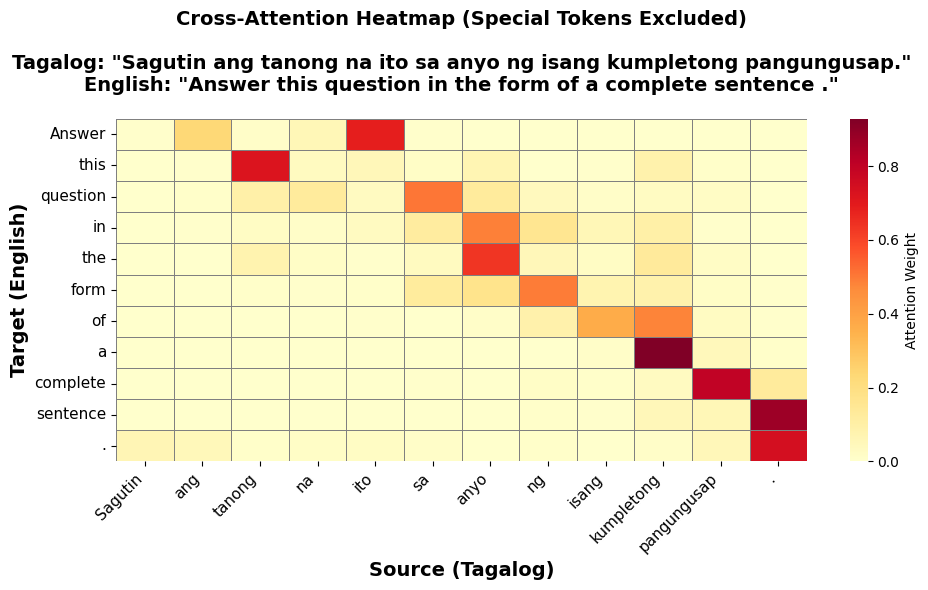


INTERPRETATION:
• Brighter/redder colors = stronger attention
• Each row shows which source words the decoder focused on
• Only content words shown (BOS/EOS/PAD excluded)
• Diagonal patterns = word-by-word translation
• Scattered patterns = reordering or idiomatic translation


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Set model to use eager attention
model.config.encoder._attn_implementation = "eager"
model.config.decoder._attn_implementation = "eager"

def visualize_attention(source_text, model, tokenizer, max_length=128):
    """
    Visualize cross-attention between source and target.
    Shows which source words the model attends to for each target word.
    """
    # Tokenize input
    inputs = tokenizer(source_text, return_tensors="pt", truncation=True, max_length=max_length)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get source tokens for labels
    source_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    source_tokens = [t for t in source_tokens if t not in ['[PAD]', '[BOS]', '[EOS]']]

    # Manual generation with attention tracking
    model.eval()
    with torch.no_grad():
        # Encode source
        encoder_outputs = model.encoder(**inputs)

        # Start with BOS token
        decoder_input_ids = torch.tensor([[tokenizer.bos_token_id]], device=model.device)

        generated_tokens = [tokenizer.bos_token_id]
        attention_weights = []

        # Generate token by token
        for _ in range(50):  # Max 50 tokens
            # Decoder forward pass
            decoder_outputs = model.decoder(
                input_ids=decoder_input_ids,
                encoder_hidden_states=encoder_outputs.last_hidden_state,
                encoder_attention_mask=inputs['attention_mask'],
                output_attentions=True,
                return_dict=True
            )

            # Get cross-attention from last layer
            # Shape: [batch, num_heads, tgt_len, src_len]
            cross_attn = decoder_outputs.cross_attentions[-1]

            # Average across heads and take last position
            # [batch, num_heads, tgt_len, src_len] -> [src_len]
            attn_weights = cross_attn[0, :, -1, :].mean(dim=0).cpu().numpy()
            attention_weights.append(attn_weights[:len(source_tokens)])

            # Get next token
            logits = decoder_outputs.logits[:, -1, :]
            next_token = logits.argmax(dim=-1)

            generated_tokens.append(next_token.item())

            # Stop if EOS
            if next_token.item() == tokenizer.eos_token_id:
                break

            # Append to decoder input
            decoder_input_ids = torch.cat([decoder_input_ids, next_token.unsqueeze(0)], dim=1)

    # Convert to text and filter out special tokens
    target_tokens = tokenizer.convert_ids_to_tokens(generated_tokens)
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # Filter out BOS, EOS from target tokens and corresponding attention weights
    filtered_target_tokens = []
    filtered_attention = []

    for i, token in enumerate(target_tokens):
        if token not in ['[BOS]', '[EOS]', '[PAD]']:
            filtered_target_tokens.append(token)
            if i < len(attention_weights):
                filtered_attention.append(attention_weights[i])

    # Create attention matrix (only for non-special tokens)
    if len(filtered_attention) > 0:
        attention_matrix = np.array(filtered_attention)
    else:
        attention_matrix = np.array([[0]])  # Fallback

    # Create visualization
    fig_height = max(6, len(filtered_target_tokens) * 0.4)
    fig_width = max(10, len(source_tokens) * 0.6)

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        attention_matrix,
        xticklabels=source_tokens,
        yticklabels=filtered_target_tokens,
        cmap='YlOrRd',
        cbar_kws={'label': 'Attention Weight'},
        linewidths=0.5,
        linecolor='gray',
        square=False,
        vmin=0,
        vmax=attention_matrix.max() if attention_matrix.size > 0 else 1
    )

    plt.xlabel('Source (Tagalog)', fontsize=14, fontweight='bold')
    plt.ylabel('Target (English)', fontsize=14, fontweight='bold')
    plt.title(f'Cross-Attention Heatmap (Special Tokens Excluded)\n\nTagalog: "{source_text}"\nEnglish: "{generated_text}"',
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()

    return plt.gcf(), attention_matrix, generated_text

# Test it!
print("Generating attention visualization...\n")
sample = "Sagutin ang tanong na ito sa anyo ng isang kumpletong pangungusap."
fig, attn, translation = visualize_attention(sample, model, tokenizer)
plt.show()

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
print("• Brighter/redder colors = stronger attention")
print("• Each row shows which source words the decoder focused on")
print("• Only content words shown (BOS/EOS/PAD excluded)")
print("• Diagonal patterns = word-by-word translation")
print("• Scattered patterns = reordering or idiomatic translation")

I tested a couple of examples, and majority of them had diagonal cross-attention patterns (which suggests word-by-word translation). But I noticed that the English words were attending to the word right **BEFORE** the direct Tagalog translation.

I wanted to analyze this pattern a bit more:


SOURCE:  Sagutin ang tanong na ito sa anyo ng isang kumpletong pangungusap.
TRANSLATION: Answer this question in the form of a complete sentence .

📊 DIAGONAL LAG ANALYSIS:

   0. 'Answer      ' → 'ito' (pos 4, lag: +4)
      Top attention: ito(0.687), ang(0.229)
   1. 'this        ' → 'tanong' (pos 2, lag: +1)
      Top attention: tanong(0.720), kumpletong(0.085)
   2. 'question    ' → 'sa' (pos 5, lag: +3)
      Top attention: sa(0.504), na(0.129)
   3. 'in          ' → 'anyo' (pos 6, lag: +3)
      Top attention: anyo(0.488), ng(0.158)
   4. 'the         ' → 'anyo' (pos 6, lag: +2)
      Top attention: anyo(0.636), kumpletong(0.133)
   5. 'form        ' → 'ng' (pos 7, lag: +2)
      Top attention: ng(0.495), anyo(0.171)
   6. 'of          ' → 'kumpletong' (pos 9, lag: +3)
      Top attention: kumpletong(0.482), isang(0.367)
   7. 'a           ' → 'kumpletong' (pos 9, lag: +2)
      Top attention: kumpletong(0.928), pangungusap(0.045)
   8. 'complete    ' → 'pangungusap' (pos 10, la

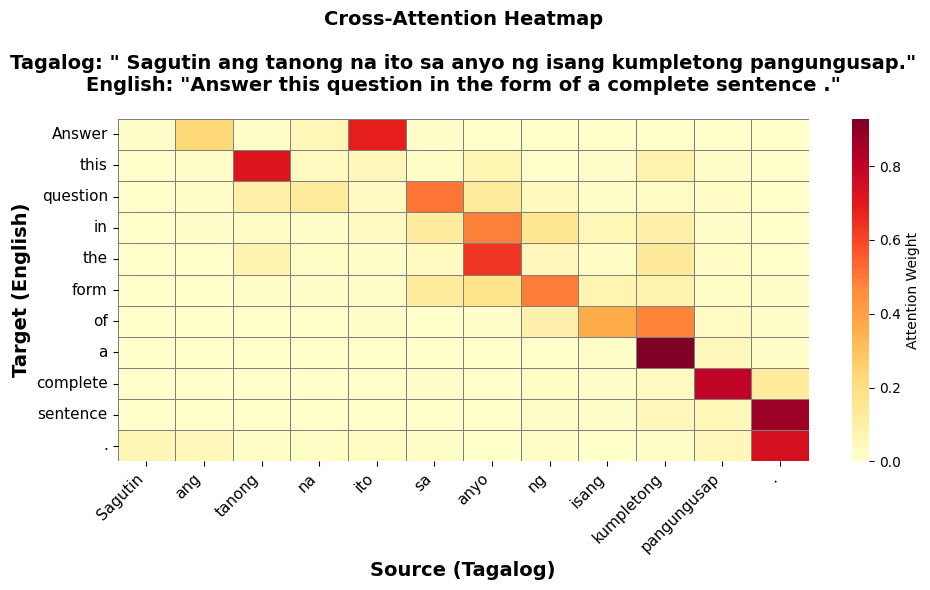


SOURCE:  Nagpaplano ka ng panlabas na kaganapan para sa 20 tao. Bumuo ng 3 posibleng venue
TRANSLATION: You are planning an outdoor event for the 20 people . Generate a 3 possible venue

📊 DIAGONAL LAG ANALYSIS:

   0. 'You         ' → 'plano' (pos 1, lag: +1)
      Top attention: plano(0.435), Nagpa(0.341)
   1. 'are         ' → 'plano' (pos 1, lag: +0)
      Top attention: plano(0.519), Nagpa(0.243)
   2. 'planning    ' → 'panlabas' (pos 4, lag: +2)
      Top attention: panlabas(0.508), ng(0.244)
   3. 'an          ' → 'panlabas' (pos 4, lag: +1)
      Top attention: panlabas(0.781), kaganapan(0.163)
   4. 'outdoor     ' → 'kaganapan' (pos 6, lag: +2)
      Top attention: kaganapan(0.923), venue(0.021)
   5. 'event       ' → 'para' (pos 7, lag: +2)
      Top attention: para(0.260), sa(0.201)
   6. 'for         ' → '20' (pos 9, lag: +3)
      Top attention: 20(0.857), sa(0.070)
   7. 'the         ' → '20' (pos 9, lag: +2)
      Top attention: 20(0.946), tao(0.021)
   8. '20          

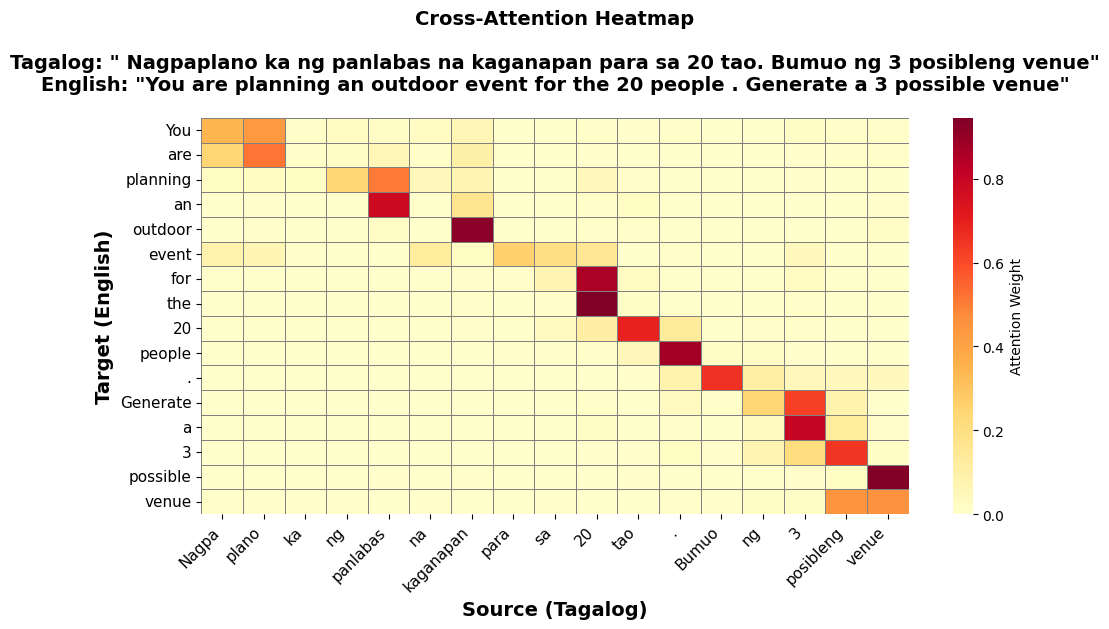


SOURCE:  Ilarawan ang sumusunod na tanawin gamit ang mga salita
TRANSLATION: Describe the following landscape using words

📊 DIAGONAL LAG ANALYSIS:

   0. 'Describe    ' → 'ang' (pos 1, lag: +1)
      Top attention: ang(0.425), sumusunod(0.412)
   1. 'the         ' → 'sumusunod' (pos 2, lag: +1)
      Top attention: sumusunod(0.500), ang(0.189)
   2. 'following   ' → 'tanawin' (pos 4, lag: +2)
      Top attention: tanawin(0.989), salita(0.007)
   3. 'landscape   ' → 'gamit' (pos 5, lag: +2)
      Top attention: gamit(0.591), tanawin(0.141)
   4. 'using       ' → 'salita' (pos 8, lag: +4)
      Top attention: salita(0.632), mga(0.147)
   5. 'words       ' → 'ang' (pos 6, lag: +1)
      Top attention: ang(0.479), gamit(0.167)

📈 SUMMARY:
   Average lag: +1.83 positions
   Std deviation: 1.07
   Range: +1 to +4

💡 INTERPRETATION:
   📍 English generation lags 1.8 positions behind
   → Model reads ahead in source for context


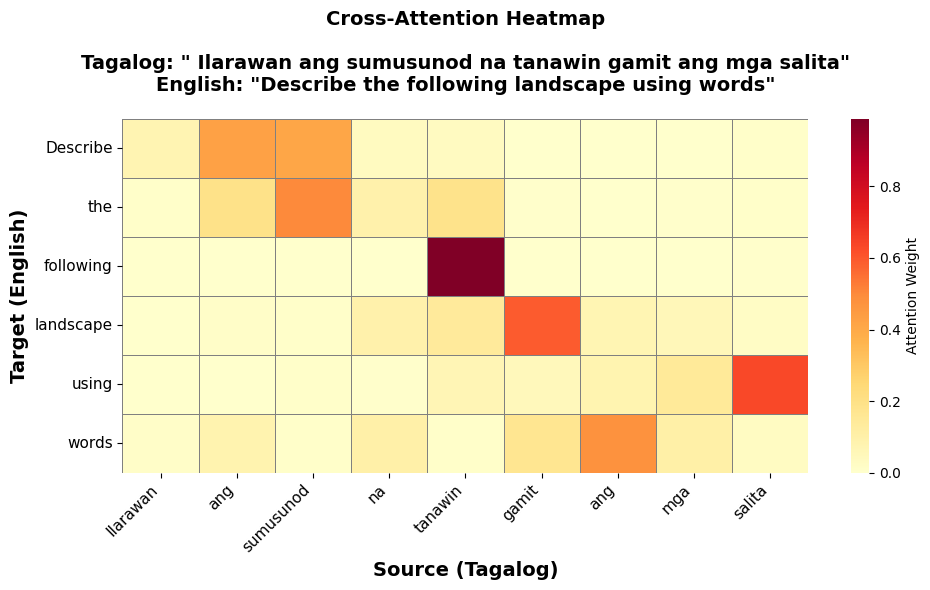


SOURCE: Lumikha ng isang halimbawa para sa sumusunod na pagtuturo. Ang output ay dapat na isang halimbawa.
TRANSLATION: Create an example for the following instruction . Output should be an example .

📊 DIAGONAL LAG ANALYSIS:

   0. 'Create      ' → 'halimbawa' (pos 3, lag: +3)
      Top attention: halimbawa(0.408), isang(0.289)
   1. 'an          ' → 'halimbawa' (pos 3, lag: +2)
      Top attention: halimbawa(0.743), ng(0.052)
   2. 'example     ' → 'sa' (pos 5, lag: +3)
      Top attention: sa(0.446), para(0.331)
   3. 'for         ' → 'sumusunod' (pos 6, lag: +3)
      Top attention: sumusunod(0.404), sa(0.340)
   4. 'the         ' → 'sumusunod' (pos 6, lag: +2)
      Top attention: sumusunod(0.526), sa(0.206)
   5. 'following   ' → 'pagtuturo' (pos 8, lag: +3)
      Top attention: pagtuturo(0.939), sumusunod(0.025)
   6. 'instruction ' → '.' (pos 9, lag: +3)
      Top attention: .(0.710), pagtuturo(0.132)
   7. '.           ' → 'output' (pos 11, lag: +4)
      Top attention: outpu

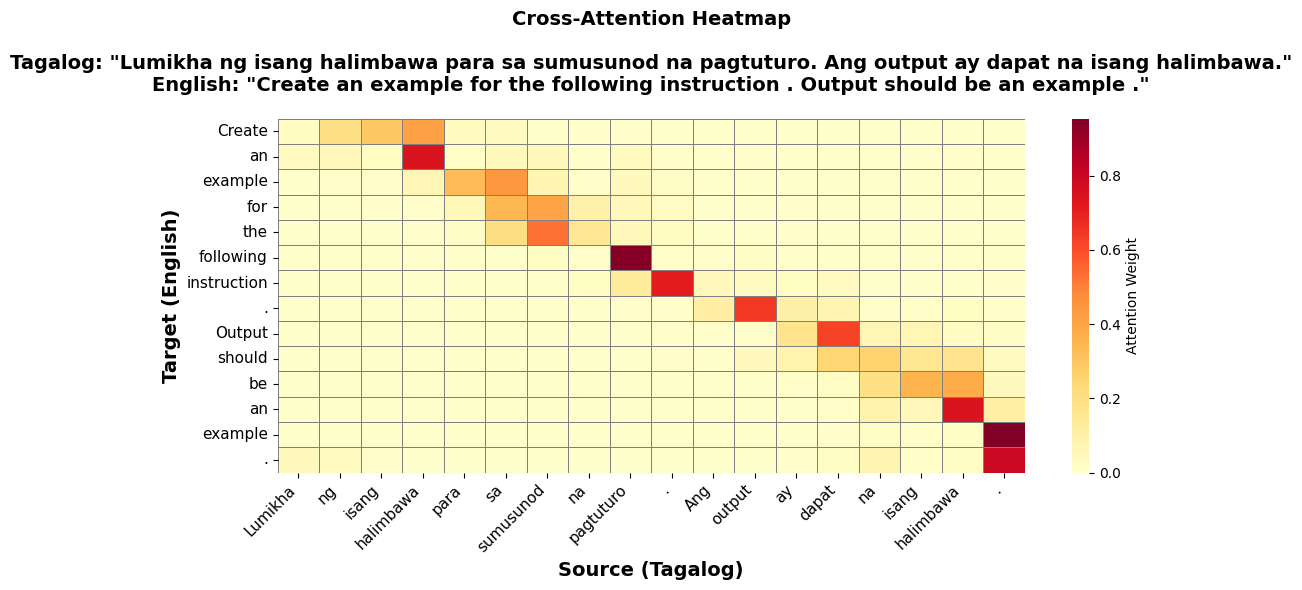


SOURCE:  Tama ba ang pahayag?
TRANSLATION: Is the statement true ?

📊 DIAGONAL LAG ANALYSIS:

   0. 'Is          ' → 'pahayag' (pos 3, lag: +3)
      Top attention: pahayag(0.419), Tama(0.204)
   1. 'the         ' → 'pahayag' (pos 3, lag: +2)
      Top attention: pahayag(0.988), ?(0.006)
   2. 'statement   ' → 'Tama' (pos 0, lag: -2)
      Top attention: Tama(0.695), pahayag(0.153)
   3. 'true        ' → 'ang' (pos 2, lag: -1)
      Top attention: ang(0.376), ?(0.319)
   4. '?           ' → '?' (pos 4, lag: +0)
      Top attention: ?(0.419), Tama(0.294)

📈 SUMMARY:
   Average lag: +0.40 positions
   Std deviation: 1.85
   Range: -2 to +3

💡 INTERPRETATION:
   ✅ Nearly perfect diagonal alignment


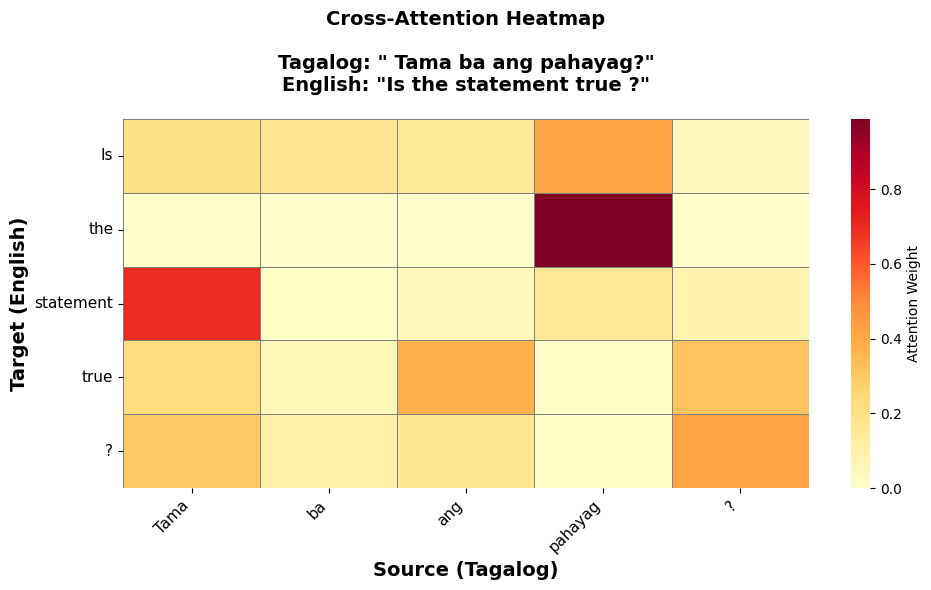


SOURCE:  Ano ang kahulugan ng salawikain na "better to be safe than sorry"?
TRANSLATION: What is the meaning of the proverb " to be more safe than sorry "?

📊 DIAGONAL LAG ANALYSIS:

   0. 'What        ' → 'kahulugan' (pos 2, lag: +2)
      Top attention: kahulugan(0.405), ang(0.349)
   1. 'is          ' → 'kahulugan' (pos 2, lag: +1)
      Top attention: kahulugan(0.332), ang(0.221)
   2. 'the         ' → 'kahulugan' (pos 2, lag: +0)
      Top attention: kahulugan(0.764), salawikain(0.146)
   3. 'meaning     ' → 'ng' (pos 3, lag: +0)
      Top attention: ng(0.518), kahulugan(0.159)
   4. 'of          ' → 'salawikain' (pos 4, lag: +0)
      Top attention: salawikain(0.626), ng(0.178)
   5. 'the         ' → 'salawikain' (pos 4, lag: -1)
      Top attention: salawikain(0.965), "(0.023)
   6. 'proverb     ' → '"' (pos 6, lag: +0)
      Top attention: "(0.644), na(0.191)
   7. '"           ' → 'better' (pos 7, lag: +0)
      Top attention: better(0.737), be(0.086)
   8. 'to          ' → '

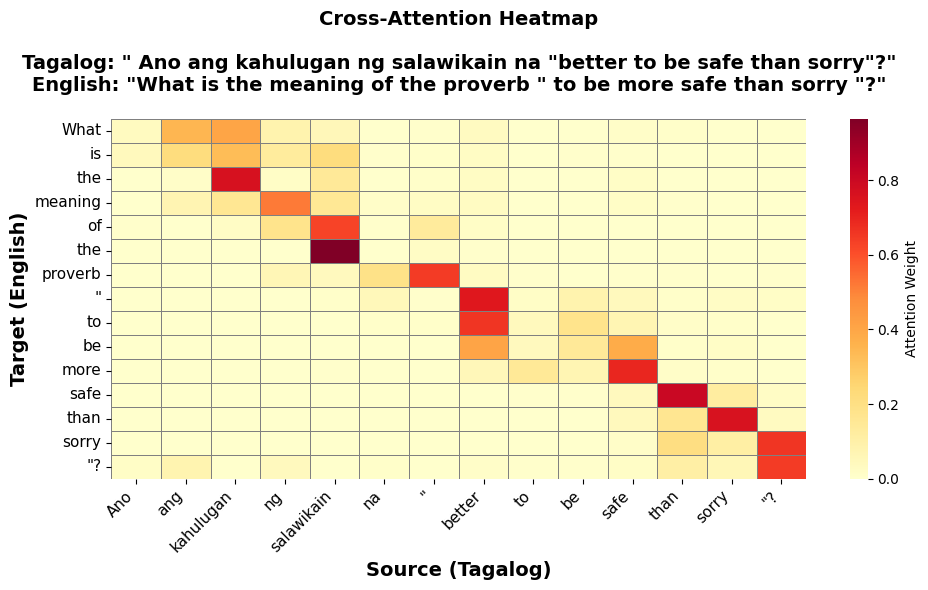


SOURCE:  Ipaliwanag kung bakit may two-party system ang US.
TRANSLATION: Explain why there is a two - party system of the US .

📊 DIAGONAL LAG ANALYSIS:

   0. 'Explain     ' → 'bakit' (pos 2, lag: +2)
      Top attention: bakit(0.790), kung(0.113)
   1. 'why         ' → 'may' (pos 3, lag: +2)
      Top attention: may(0.355), two(0.290)
   2. 'there       ' → 'may' (pos 3, lag: +1)
      Top attention: may(0.358), two(0.152)
   3. 'is          ' → 'two' (pos 4, lag: +1)
      Top attention: two(0.290), may(0.237)
   4. 'a           ' → 'two' (pos 4, lag: +0)
      Top attention: two(0.486), party(0.229)
   5. 'two         ' → 'party' (pos 6, lag: +1)
      Top attention: party(0.441), -(0.278)
   6. '-           ' → 'party' (pos 6, lag: +0)
      Top attention: party(0.581), US(0.240)
   7. 'party       ' → 'system' (pos 7, lag: +0)
      Top attention: system(0.548), party(0.237)
   8. 'system      ' → 'ang' (pos 8, lag: +0)
      Top attention: ang(0.358), -(0.163)
   9. 'of        

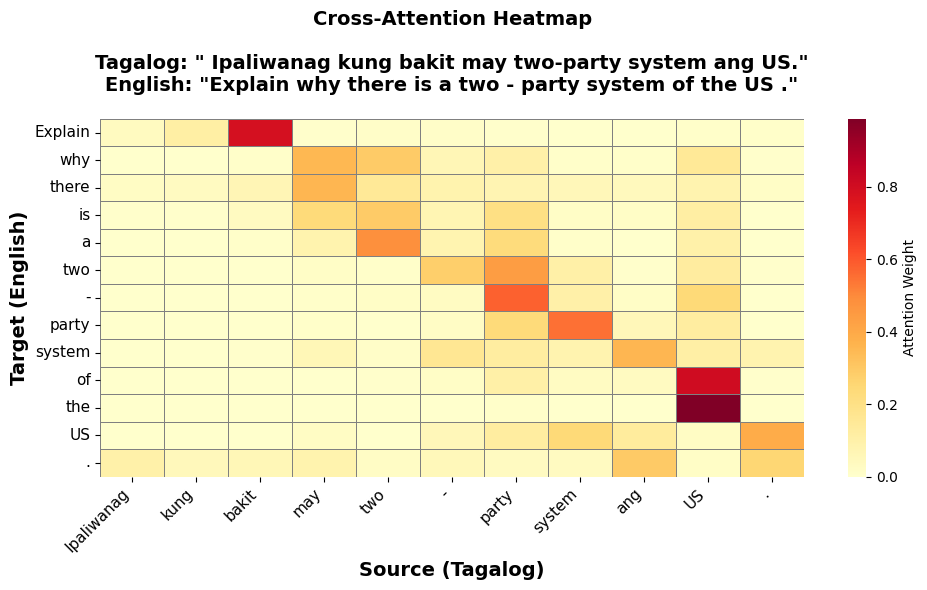


SOURCE: Magbigay ng dalawang halimbawa kung paano magagamit ang machine learning sa isang negosyo.
TRANSLATION: Give two examples of how machine learning can be used in a business .

📊 DIAGONAL LAG ANALYSIS:

   0. 'Give        ' → 'dalawang' (pos 2, lag: +2)
      Top attention: dalawang(0.631), ng(0.263)
   1. 'two         ' → 'halimbawa' (pos 3, lag: +2)
      Top attention: halimbawa(0.721), dalawang(0.137)
   2. 'examples    ' → 'paano' (pos 5, lag: +3)
      Top attention: paano(0.257), kung(0.243)
   3. 'of          ' → 'paano' (pos 5, lag: +2)
      Top attention: paano(0.624), kung(0.180)
   4. 'how         ' → 'machine' (pos 8, lag: +4)
      Top attention: machine(0.849), negosyo(0.068)
   5. 'machine     ' → 'learning' (pos 9, lag: +4)
      Top attention: learning(0.666), machine(0.109)
   6. 'learning    ' → 'magagamit' (pos 6, lag: +0)
      Top attention: magagamit(0.656), ang(0.123)
   7. 'can         ' → 'magagamit' (pos 6, lag: -1)
      Top attention: magagamit(0.5

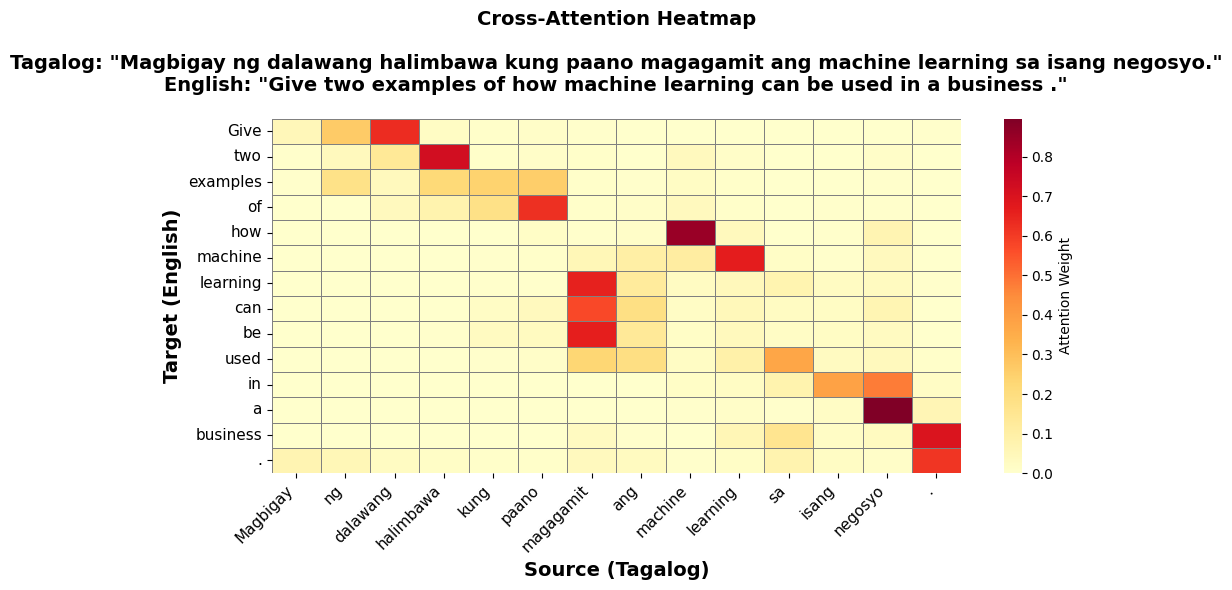


SOURCE:  Magbigay ng maikling paglalarawan ng terminong 'interoperability sa antas ng populasyon'.
TRANSLATION: Provide a brief description of the term ' convergence ability to population level '.

📊 DIAGONAL LAG ANALYSIS:

   0. 'Provide     ' → 'maikling' (pos 2, lag: +2)
      Top attention: maikling(0.621), ng(0.320)
   1. 'a           ' → 'maikling' (pos 2, lag: +1)
      Top attention: maikling(0.955), paglalarawan(0.013)
   2. 'brief       ' → 'paglalarawan' (pos 3, lag: +1)
      Top attention: paglalarawan(0.788), terminong(0.094)
   3. 'description ' → 'ng' (pos 4, lag: +1)
      Top attention: ng(0.568), '(0.159)
   4. 'of          ' → ''' (pos 6, lag: +2)
      Top attention: '(0.428), terminong(0.376)
   5. 'the         ' → 'terminong' (pos 5, lag: +0)
      Top attention: terminong(0.793), '(0.136)
   6. 'term        ' → ''' (pos 6, lag: +0)
      Top attention: '(0.754), ng(0.133)
   7. ''           ' → 'interoper' (pos 7, lag: +0)
      Top attention: interoper(0.834),

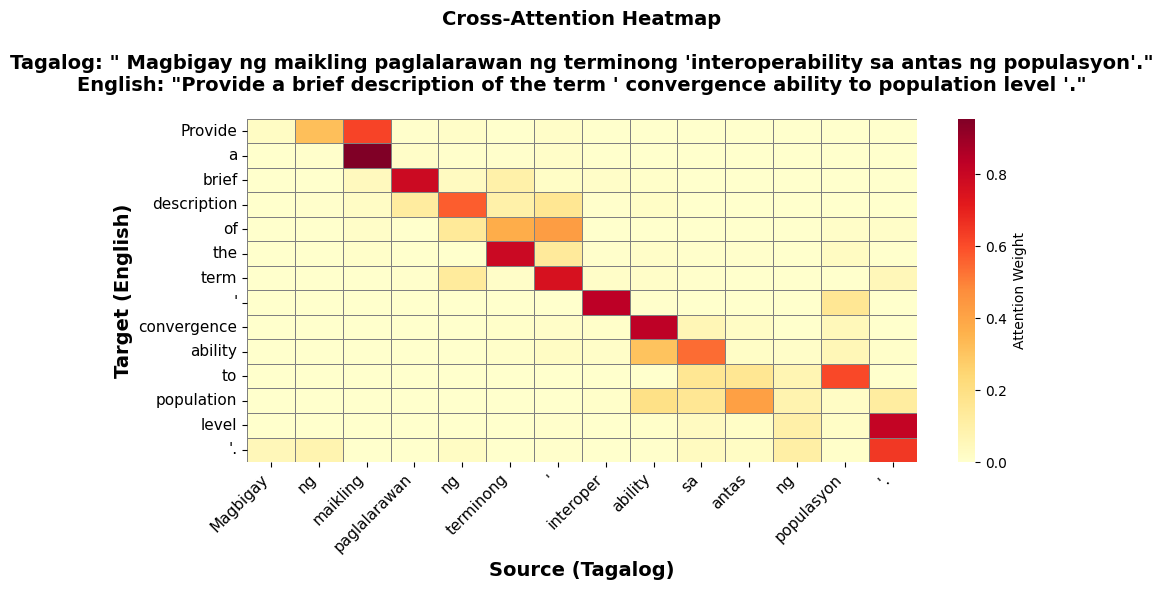


SOURCE:  Isulat muli ang pangungusap gamit ang ibinigay na salita.
TRANSLATION: Rewrite the sentence using the given word .

📊 DIAGONAL LAG ANALYSIS:

   0. 'Rewrite     ' → 'ang' (pos 2, lag: +2)
      Top attention: ang(0.389), pangungusap(0.296)
   1. 'the         ' → 'pangungusap' (pos 3, lag: +2)
      Top attention: pangungusap(0.637), ibinigay(0.106)
   2. 'sentence    ' → 'gamit' (pos 4, lag: +2)
      Top attention: gamit(0.648), ang(0.166)
   3. 'using       ' → 'ibinigay' (pos 6, lag: +3)
      Top attention: ibinigay(0.497), ang(0.256)
   4. 'the         ' → 'ibinigay' (pos 6, lag: +2)
      Top attention: ibinigay(0.529), na(0.210)
   5. 'given       ' → 'salita' (pos 8, lag: +3)
      Top attention: salita(0.655), na(0.247)
   6. 'word        ' → '.' (pos 9, lag: +3)
      Top attention: .(0.715), na(0.220)
   7. '.           ' → '.' (pos 9, lag: +2)
      Top attention: .(0.482), na(0.267)

📈 SUMMARY:
   Average lag: +2.38 positions
   Std deviation: 0.48
   Range: +2 t

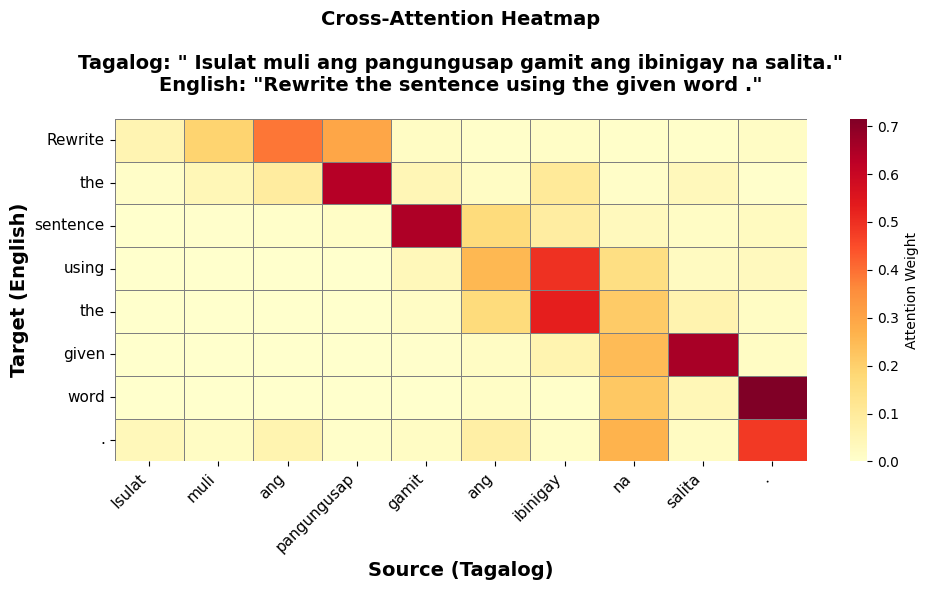

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Set model to use eager attention
model.config.encoder._attn_implementation = "eager"
model.config.decoder._attn_implementation = "eager"

def visualize_attention_with_analysis(source_text, model, tokenizer, max_length=128):
    """
    Visualize cross-attention and analyze lag pattern.
    """
    # Tokenize input
    inputs = tokenizer(source_text, return_tensors="pt", truncation=True, max_length=max_length)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get source tokens for labels
    source_tokens_all = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    source_tokens = [t for t in source_tokens_all if t not in ['[PAD]', '[BOS]', '[EOS]']]

    # Manual generation with attention tracking
    model.eval()
    with torch.no_grad():
        # Encode source
        encoder_outputs = model.encoder(**inputs)

        # Start with BOS token
        decoder_input_ids = torch.tensor([[tokenizer.bos_token_id]], device=model.device)

        generated_tokens = [tokenizer.bos_token_id]
        attention_weights = []

        # Generate token by token
        for _ in range(50):
            decoder_outputs = model.decoder(
                input_ids=decoder_input_ids,
                encoder_hidden_states=encoder_outputs.last_hidden_state,
                encoder_attention_mask=inputs['attention_mask'],
                output_attentions=True,
                return_dict=True
            )

            cross_attn = decoder_outputs.cross_attentions[-1]
            attn_weights = cross_attn[0, :, -1, :].mean(dim=0).cpu().numpy()
            attention_weights.append(attn_weights[:len(source_tokens)])

            logits = decoder_outputs.logits[:, -1, :]
            next_token = logits.argmax(dim=-1)
            generated_tokens.append(next_token.item())

            if next_token.item() == tokenizer.eos_token_id:
                break

            decoder_input_ids = torch.cat([decoder_input_ids, next_token.unsqueeze(0)], dim=1)

    # Convert to text and filter
    target_tokens_all = tokenizer.convert_ids_to_tokens(generated_tokens)
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # Filter out special tokens
    filtered_target_tokens = []
    filtered_attention = []

    for i, token in enumerate(target_tokens_all):
        if token not in ['[BOS]', '[EOS]', '[PAD]']:
            filtered_target_tokens.append(token)
            if i < len(attention_weights):
                filtered_attention.append(attention_weights[i])

    attention_matrix = np.array(filtered_attention) if filtered_attention else np.array([[0]])

    # === ANALYSIS SECTION ===
    print("\n" + "="*70)
    print(f"SOURCE: {source_text}")
    print(f"TRANSLATION: {generated_text}")
    print("="*70)

    print("\n📊 DIAGONAL LAG ANALYSIS:\n")

    lags = []
    for i in range(len(filtered_target_tokens)):
        if i < len(attention_matrix) and len(source_tokens) > 0:
            peak_idx = attention_matrix[i].argmax()
            peak_source = source_tokens[peak_idx] if peak_idx < len(source_tokens) else "?"
            expected_idx = min(i, len(source_tokens) - 1)
            lag = peak_idx - expected_idx
            lags.append(lag)

            # Show top 2 attended words
            top_2_indices = attention_matrix[i].argsort()[-2:][::-1]
            top_2_words = [source_tokens[idx] if idx < len(source_tokens) else "?" for idx in top_2_indices]
            top_2_weights = [attention_matrix[i][idx] for idx in top_2_indices]

            print(f"  {i:2d}. '{filtered_target_tokens[i]:12s}' → '{peak_source}' (pos {peak_idx}, lag: {lag:+2d})")
            print(f"      Top attention: {top_2_words[0]}({top_2_weights[0]:.3f}), {top_2_words[1]}({top_2_weights[1]:.3f})")

    if lags:
        avg_lag = np.mean(lags)
        std_lag = np.std(lags)
        print(f"\n📈 SUMMARY:")
        print(f"   Average lag: {avg_lag:+.2f} positions")
        print(f"   Std deviation: {std_lag:.2f}")
        print(f"   Range: {min(lags):+d} to {max(lags):+d}")

        print(f"\n💡 INTERPRETATION:")
        if abs(avg_lag) < 0.5:
            print("   ✅ Nearly perfect diagonal alignment")
        elif avg_lag > 1:
            print(f"   📍 English generation lags {avg_lag:.1f} positions behind")
            print("   → Model reads ahead in source for context")
        elif avg_lag < -1:
            print(f"   📍 English generation leads {abs(avg_lag):.1f} positions ahead")
            print("   → Possible article/function word insertion")
        else:
            print("   ✅ Good alignment with slight variation")

    # === VISUALIZATION ===
    fig_height = max(6, len(filtered_target_tokens) * 0.4)
    fig_width = max(10, len(source_tokens) * 0.6)

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        attention_matrix,
        xticklabels=source_tokens,
        yticklabels=filtered_target_tokens,
        cmap='YlOrRd',
        cbar_kws={'label': 'Attention Weight'},
        linewidths=0.5,
        linecolor='gray',
        square=False,
        vmin=0,
        vmax=attention_matrix.max() if attention_matrix.size > 0 else 1
    )

    plt.xlabel('Source (Tagalog)', fontsize=14, fontweight='bold')
    plt.ylabel('Target (English)', fontsize=14, fontweight='bold')
    plt.title(f'Cross-Attention Heatmap\n\nTagalog: "{source_text}"\nEnglish: "{generated_text}"',
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()

    return plt.gcf(), attention_matrix, generated_text


#sample = "Sagutin ang tanong na ito sa anyo ng isang kumpletong pangungusap."

for i in range(10):
    sample = ds['test'][i]
    fig, attn, translation = visualize_attention_with_analysis(sample['tagalog'], model, tokenizer)
    plt.show()

The "lagged" diagonal does check out! But I noticed that this applies mainly when the Tagalog sentence follows **karaniwan** (predicate-first) form rather than **di-karaniwan** (subject-first). In Tagalog, **karaniwan** is the more common order: the predicate (comment) comes first and the subject (topic) second—e.g. *Tama ba ang pahayag?* (Is the statement correct?). **Di-karaniwan** is the other way around: subject then predicate—e.g. *Ang pahayag ay tama* (The statement is correct)—so it’s closer to English word order. For a karaniwan sentence like "Tama ba ang pahayag?", the model has to reorder when producing English ("Is the statement correct?"), so the attention heatmap often looks less like a clean diagonal and more scattered, with *statement* aligning to *pahayag* and *correct* to *Tama* across different positions. So the nice lagged diagonal shows up more when Tagalog and English line up in similar order; when karaniwan inverts the order, the alignment pattern is messier but the model is still reordering correctly.